In [1]:
import numpy as np
import mne
import pyxdf
import matplotlib.pyplot as plt
from pathlib import Path

from scipy import signal

import util.preprocess_util as preprocess
import util.analysis_util as analysis

%load_ext autoreload
%autoreload 2

DATA_DIR = Path('./data')
DATA_FILE_NAME = 'Sandra_MI_1h.xdf'
DATA_FILE = DATA_DIR / DATA_FILE_NAME

# Read in xdf file(s)

In [2]:
# Read data
streams, header = pyxdf.load_xdf(DATA_FILE)

In [3]:
# Extract streams from xdf data

def find_stream(name, streams):
    for stream in streams:
        if stream['info']['name'][0] == name:
            return stream
    
    print(f'Error: stream "{name}" not found')

unicorn_stream = find_stream('Unicorn', streams)
fs = int(unicorn_stream['info']['nominal_srate'][0]) # 250 Hz

openvibe_stream = find_stream('openvibeMarkers', streams)
openvibe_stream['time_series'] = np.array(openvibe_stream['time_series'])

print(f"EEG data shape: {unicorn_stream['time_series'].shape}")
print(f"Markers shape: {openvibe_stream['time_series'].shape}")
print(f'Sampling Frequency: {fs}')

EEG data shape: (1023780, 17)
Markers shape: (1213, 1)
Sampling Frequency: 250


# Extract Event Data

From the Open Vibe Marker Stream

- `event_codes`: array of codes sent to the marker stream at the start of each event 
- `event_time_stamps`: array of timestamps signifying the start of each event

The mapping for this particular paradigm was:
- 'beep': 0, 
- 'cue_no_blink': 1, 
- 'imagery_no_blink': 2, 
- 'break': 3, 
- 'cue_handR': 4, 
- 'imagery_handR': 5, 
- 'cue_handL': 6, 
- 'imagery_handL': 7

In [4]:
def unique(input_list):
    unique_items = []
    for x in input_list:
        if x not in unique_items:
            unique_items.append(x)
    
    return unique_items

def build_unique_mapping(unique_labels):
    unique_mapping = {}
    for i, label in enumerate(unique_labels):
        unique_mapping[label] = i
    
    return unique_mapping

In [5]:
# Get event codes
event_labels = [x[0] for x in openvibe_stream['time_series']]
unique_labels = unique(event_labels)
label2code = build_unique_mapping(unique_labels)
event_codes = np.array([label2code[x] for x in event_labels])

# Get event time stamps
event_time_stamps = np.array(openvibe_stream['time_stamps'])

assert event_time_stamps.shape == event_codes.shape

print(f'Total number of events: {event_codes.shape[0]}')
print(f'Event code for left MI: {label2code["imagery_handL"]}')
print(f'Event code for left MI: {label2code["imagery_handR"]}')
print(f'Number of left MI events: {np.sum(event_codes == label2code["imagery_handL"])}')
print(f'Number of right MI events: {np.sum(event_codes == label2code["imagery_handR"])}')

Total number of events: 1213
Event code for left MI: 7
Event code for left MI: 5
Number of left MI events: 200
Number of right MI events: 200


# Preprocess EEG data

In [6]:
# Extract the relevent EEG channels
eeg_data = unicorn_stream['time_series'][:,0:8].T
eeg_data.shape

(8, 1023780)

## Rereference the EEG data

In [7]:
# Rereference according to the mean
eeg_data = eeg_data - np.mean(eeg_data, axis=0)

## Filter EEG data

In [8]:
lf = 8 #alpha band
hf = 16 
nf = 50 #notch
lf_b = 12.5 #beta band
hf_b = 30

# Design notch filter
b, a = signal.iirnotch(w0=nf, Q=7, fs=fs)
freq, h = signal.freqz(b, a, fs = fs)

# Apply notch and bandpass filters
eeg_notched = signal.filtfilt(b, a, eeg_data, axis=1)
eeg_notched_bp = preprocess.bandpass(eeg_notched, lf=lf, hf=hf, fs=fs, ftype='butter')
# bp for beta band
eeg_notched_bp_b = preprocess.bandpass(eeg_notched, lf=lf_b, hf=hf_b, fs=fs, ftype='butter')

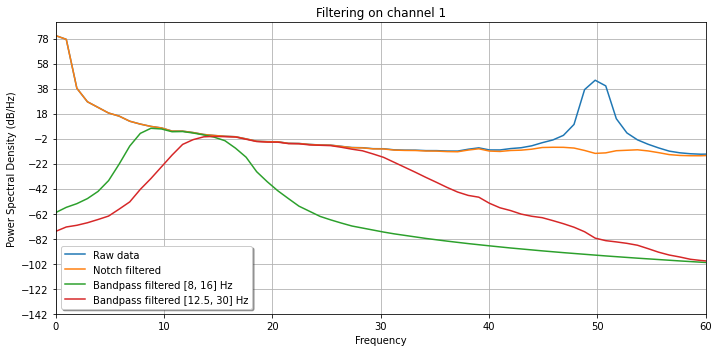

In [9]:
channel_number = preprocess.name2channel('C3')

# Show the effect of the filter
plt.figure(figsize=(10,5))
plt.title(f'Filtering on channel {channel_number}')
plt.psd(eeg_data[channel_number], Fs=fs, label='Raw data')
plt.psd(eeg_notched[channel_number], Fs=fs, label='Notch filtered')
plt.psd(eeg_notched_bp[channel_number], Fs=fs, label=f'Bandpass filtered [{lf}, {hf}] Hz')
# beta included
plt.psd(eeg_notched_bp_b[channel_number], Fs=fs, label=f'Bandpass filtered [{lf_b}, {hf_b}] Hz')
plt.tight_layout()
plt.legend(loc='lower left', shadow=True)
plt.xlim([0,60])
plt.show()

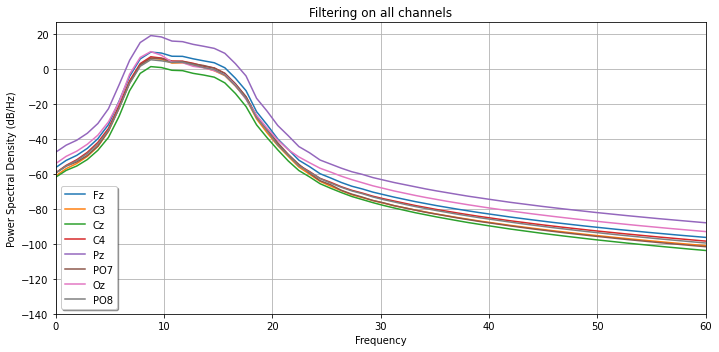

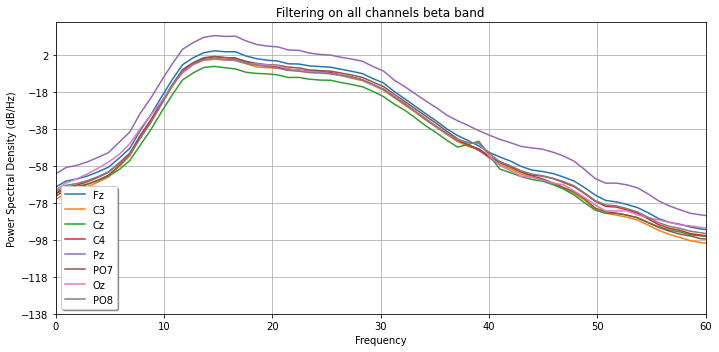

In [10]:
# alpha band 
plt.figure(figsize=(10,5))
plt.title(f'Filtering on all channels')

for i in range(eeg_data.shape[0]):
    plt.psd(eeg_notched_bp[i], Fs=fs, label=f'{preprocess.channel2name(i)}')

plt.tight_layout()
plt.legend(loc='lower left', shadow=True)
plt.xlim([0,60])
# plt.show()

# beta band 
plt.figure(figsize=(10,5))
plt.title(f'Filtering on all channels beta band')

for i in range(eeg_data.shape[0]):
    plt.psd(eeg_notched_bp_b[i], Fs=fs, label=f'{preprocess.channel2name(i)}')

plt.tight_layout()
plt.legend(loc='lower left', shadow=True)
plt.xlim([0,60])
plt.show()

# Build an event time-series/stream

Create a time series from the event codes which is the same length as the EEG data

In [11]:
eeg_timestamps = unicorn_stream['time_stamps']
eeg_start_time = eeg_timestamps[0]
label_start_time = event_time_stamps[0]
experiment_start_time = min(label_start_time, eeg_start_time)

relative_eeg_timestamps = eeg_timestamps - experiment_start_time
relative_event_time_stamps = event_time_stamps - experiment_start_time

In [12]:
def find_closest_time(timestamp, eeg_timestamps):
    return np.where(eeg_timestamps > timestamp)[0][0]

In [13]:
# Get indices of events
indices = [0]

for timestamp in relative_event_time_stamps:
    indices.append(find_closest_time(timestamp, relative_eeg_timestamps))

# Build event time series (use -1 since 0 is actually a code for no blinking)
event_time_series = np.zeros_like(eeg_timestamps) - 1

for i, (_, code) in enumerate(zip(indices[1:], event_codes)):
    idx = i+1
    if idx < len(indices)-1:
        event_time_series[indices[idx]:indices[idx+1]] = code
    else:
        event_time_series[indices[idx]:] = code

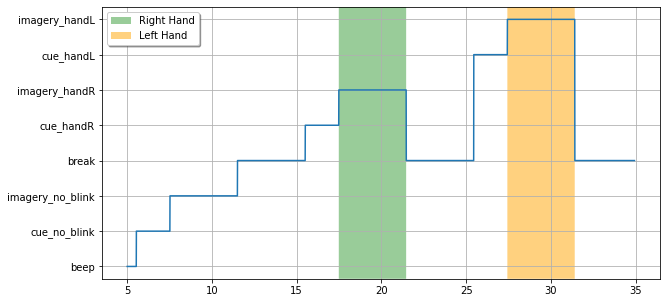

In [15]:
window = 30
start_time = 5
t = np.arange(0, window*fs, 1/fs)

fig, ax = plt.subplots(figsize=(10,5))
x = relative_eeg_timestamps[start_time*fs:(start_time + window)*fs]
y = event_time_series[start_time*fs:(start_time + window)*fs]
ax.plot(x, y, '-')

import matplotlib.transforms as mtransforms
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)

ax.fill_between(x, 0, 1, where= (y == 5),
                facecolor='green', alpha=0.4, transform=trans, label='Right Hand')
ax.fill_between(x, 0, 1, where= (y == 7),
                facecolor='orange', alpha=0.5, transform=trans, label='Left Hand')

event_labels = list(label2code.keys())
plt.yticks(range(len(event_labels)), event_labels)
plt.grid()
plt.legend(shadow=True)
plt.show()

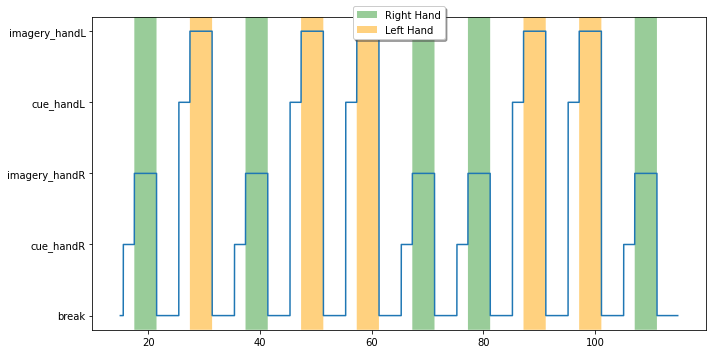

In [16]:
window = 100
start_time = 15
x = relative_eeg_timestamps[start_time*fs:(start_time + window)*fs]
y = event_time_series[start_time*fs:(start_time + window)*fs]

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x, y)

import matplotlib.transforms as mtransforms
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)

ax.fill_between(x, 0, 1, where= (y == 5),
                facecolor='green', alpha=0.4, transform=trans, label='Right Hand')
ax.fill_between(x, 0, 1, where= (y == 7),
                facecolor='orange', alpha=0.5, transform=trans, label='Left Hand')

event_labels = list(label2code.keys())
plt.yticks(range(len(event_labels)), event_labels)
plt.ylim([2.8,7.2])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), shadow=True, fancybox=True)
plt.tight_layout()
plt.show()

# Normalise EEG data

In [17]:
eeg_notched_bp_norm = preprocess.normalise_eeg(eeg_notched_bp)
eeg_notched_bp_norm_b = preprocess.normalise_eeg(eeg_notched_bp_b)

# Inspect EEG data with markers

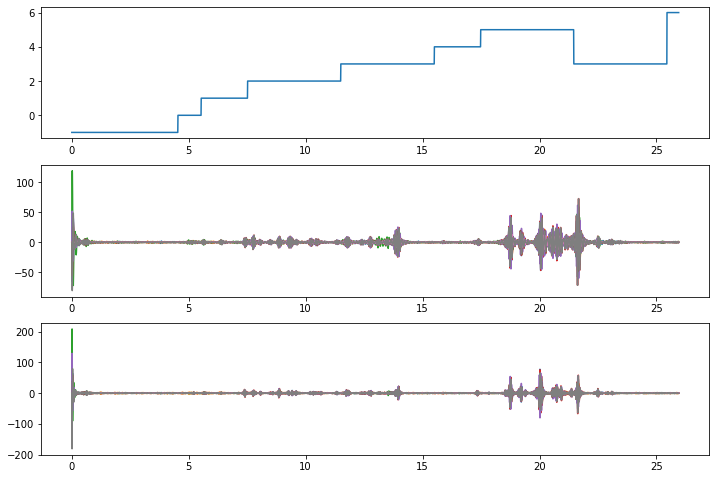

In [18]:
window = 26
start_time = 0
number_of_channels = 8

plt.subplots(figsize=(10,20), sharex=True)
plt.tight_layout()

x = relative_eeg_timestamps[start_time*fs:(start_time + window)*fs]
y1 = event_time_series[start_time*fs:(start_time + window)*fs]
plt.subplot((number_of_channels + 1),1,1)
plt.plot(x, y1)

for i in range(number_of_channels):
    y2 = eeg_notched_bp_norm[i ,start_time*fs:(start_time + window)*fs]
    plt.subplot((number_of_channels + 1), 1, 2)
    plt.plot(x, y2)

# plt.show()

# plot for beta band
for i in range(number_of_channels):
    y3 = eeg_notched_bp_norm_b[i ,start_time*fs:(start_time + window)*fs]
    plt.subplot((number_of_channels + 1), 1, 3)
    plt.plot(x, y3)

plt.show()

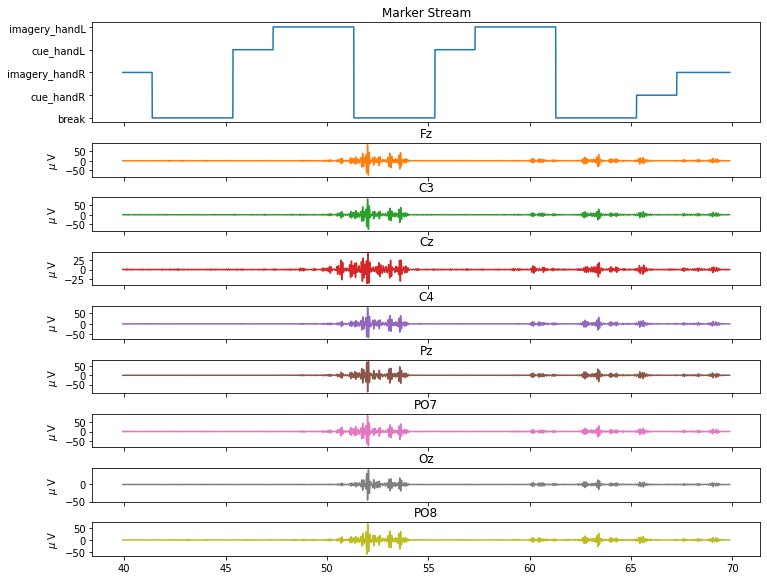

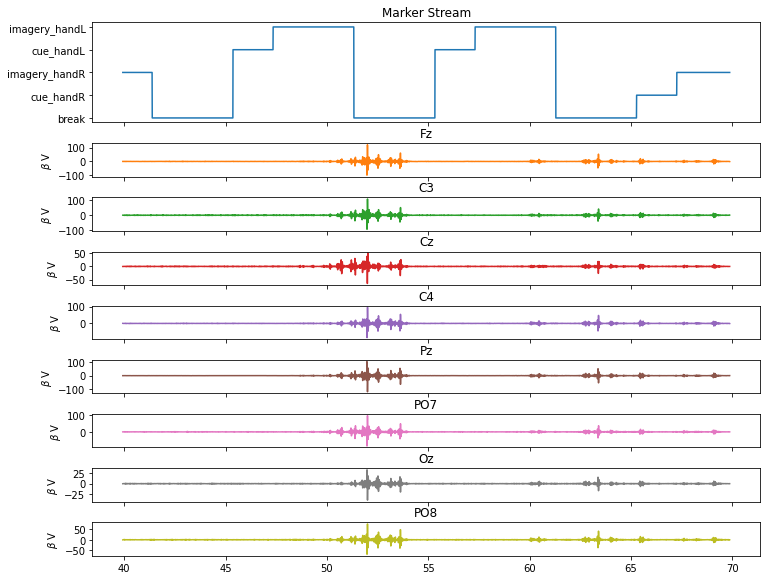

In [20]:
def plot_all(eeg_timestamps, event_time_series, eeg_data, number_of_channels=None, window=30, start_time = 15, freq_band = r'$\mu$ V'):

    if number_of_channels == None:
        number_of_channels = eeg_data.shape[0]

    colors = plt.rcParams["axes.prop_cycle"]()

    height_ratios = [1 if i>0 else 3 for i in range(number_of_channels+1)]

    fig, axs = plt.subplots(
        number_of_channels+1, 1,
        figsize=(10,8), 
        sharex=True, 
        gridspec_kw={'height_ratios': height_ratios}
    )
    plt.tight_layout()

    x = eeg_timestamps[start_time*fs:(start_time + window)*fs]
    y = event_time_series[start_time*fs:(start_time + window)*fs]

    c = next(colors)["color"]
    axs[0].plot(x, y, color=c)
    axs[0].set_title('Marker Stream')
    plt.sca(axs[0])
    plt.yticks(range(len(event_labels)), event_labels)
    axs[0].set_ylim([2.8,7.2])

    for i in range(number_of_channels):
        axs[i+1].plot(
            x, 
            eeg_data[i ,start_time*fs:(start_time + window)*fs], 
            color=next(colors)["color"]
        )
        axs[i+1].set_title(preprocess.channel2name(i))
        axs[i+1].set_ylabel(freq_band)

    plt.show()

plot_all(relative_eeg_timestamps, event_time_series, eeg_notched_bp_norm, start_time=40, freq_band = r'$\mu$ V')
# plot for beta band
plot_all(relative_eeg_timestamps, event_time_series, eeg_notched_bp_norm_b, start_time=40, freq_band = r'$\beta$ V')

# Save the data

In [21]:
data_file_name = DATA_FILE_NAME.split('.')[0]
np.save(DATA_DIR / f'{data_file_name}_eeg_data', eeg_notched_bp, allow_pickle=True)
np.save(DATA_DIR / f'{data_file_name}_eeg_data_beta', eeg_notched_bp_b, allow_pickle=True)
np.save(DATA_DIR / f'{data_file_name}_marker_stream', eeg_notched_bp, allow_pickle=True)

# ICA Experiment

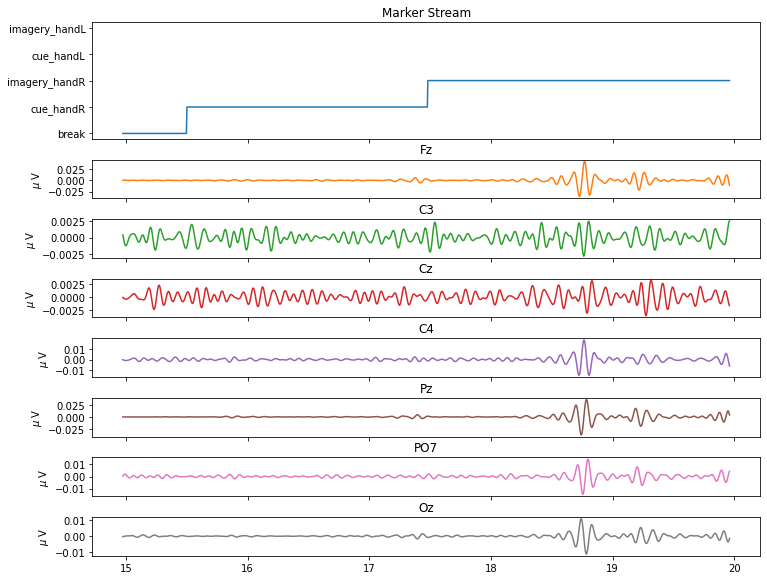

In [22]:
# from sklearn.decomposition import FastICA

# transformer = FastICA(n_components=7, random_state=0, whiten=True)


# _transformed = transformer.fit_transform(eeg_notched_bp.T)
# _transformed.shape

# plot_all(relative_eeg_timestamps, event_time_series, _transformed.T, window=5, number_of_channels=7)

# Split into trials

In [22]:
EEG = eeg_notched_bp_norm.copy()
event_onsets = event_time_stamps.copy()
cl_labs = ['imagery_handL', 'imagery_handR']
cl_codes = [label2code[code] for code in cl_labs]
nclasses = len(cl_labs)
nchannels = EEG.shape[0]

# beta band
EEG_beta = eeg_notched_bp_norm_b.copy()

# Print some information
print('Shape of EEG:', EEG.shape)
print('Sample rate:', fs)
print('Number of channels:', EEG.shape[0])
print('Channel names:', [preprocess.channel2name(channel) for channel in range(EEG.shape[0])])
print('Number of events:', len(event_onsets))
print('Event codes:', np.unique(event_codes))
print('Class labels:', cl_labs)
print('Class codes:', cl_codes)
print('Number of classes:', nclasses)

Shape of EEG: (8, 1023780)
Sample rate: 250
Number of channels: 8
Channel names: ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8']
Number of events: 1213
Event codes: [0 1 2 3 4 5 6 7]
Class labels: ['imagery_handL', 'imagery_handR']
Class codes: [7, 5]
Number of classes: 2


In [23]:
# Dictionary to store the trials in, each class gets an entry
trials = {}
markers = {} 

# beta trial dict
trials_b = {}

# The time window (in samples) to extract for each trial, here 0.5 -- 2.5 seconds
win = np.arange(int(0.5*fs), int(2.5*fs))

# Length of the time window
nsamples = len(win)

for cl_lab in cl_labs:
    event_onset_mask =  np.roll(event_time_series,1)!=event_time_series
    class_onset_mask = event_time_series == label2code[cl_lab]
    class_onset_indices = np.where(np.logical_and(
                                event_onset_mask, class_onset_mask))[0]
    
    # Allocate memory for the trials
    trials[cl_lab] = np.zeros((nchannels, nsamples, len(class_onset_indices)))
    trials_b[cl_lab] = np.zeros((nchannels, nsamples, len(class_onset_indices)))
    markers[cl_lab] = np.zeros((nsamples, len(class_onset_indices)))

    # Extract each trial
    for i, onset in enumerate(class_onset_indices):
        trials[cl_lab][:,:,i] = EEG[:, win+onset]
        trials_b[cl_lab][:,:,i] = EEG_beta[:, win+onset]
        markers[cl_lab][:, i] = event_time_series[win+onset]

print(trials['imagery_handL'].shape, trials['imagery_handR'].shape)
print(trials_b['imagery_handL'].shape, trials_b['imagery_handR'].shape)

(8, 500, 200) (8, 500, 200)
(8, 500, 200) (8, 500, 200)


# Some statistical Analysis to remove noisy trials

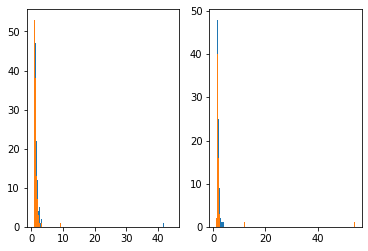

In [24]:
# check the distribution of the max_val
plt.figure()
plt.title('Distribution of the max for all trials')
plt.subplot(1, 2, 1)
plt.hist(trials['imagery_handL'].max(axis = (0,1)), bins='auto', label='Left MI Trials')
plt.hist(trials['imagery_handR'].max(axis = (0,1)), bins='auto', label='Right MI Trials')
plt.subplot(1, 2, 2)
plt.hist(trials_b['imagery_handL'].max(axis = (0,1)), bins='auto', label='Left MI Trials_beta')
plt.hist(trials_b['imagery_handR'].max(axis = (0,1)), bins='auto', label='Right MI Trials_beta')
plt.show()

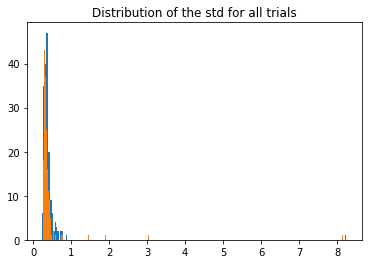

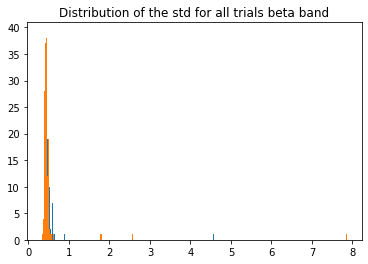

In [25]:
plt.figure()
plt.title('Distribution of the std for all trials')
plt.hist(trials['imagery_handL'].std(axis = (0,1)), bins='auto', label='Left MI Trials')
plt.hist(trials['imagery_handR'].std(axis = (0,1)), bins='auto', label='Right MI Trials')
# plt.show()

# plot beta
plt.figure()
plt.title('Distribution of the std for all trials beta band')
plt.hist(trials_b['imagery_handL'].std(axis = (0,1)), bins='auto', label=r'Left MI Trials_$\beta$')
plt.hist(trials_b['imagery_handR'].std(axis = (0,1)), bins='auto', label=r'Right MI Trials_$\beta$')
plt.show()

In [26]:
# remove bad trials

good_trials = {
    'imagery_handL': np.zeros((nchannels, nsamples,1)),
    'imagery_handR': np.zeros((nchannels, nsamples,1)),
} 

for trial in range(trials['imagery_handL'].shape[2]):
    eeg_sampleL = trials['imagery_handL'][:,:,trial]
    if eeg_sampleL.std(axis = (0,1)) < 0.7 and eeg_sampleL.max(axis = (0,1)) < 4:
        good_trials['imagery_handL'] = np.concatenate(
            [good_trials['imagery_handL'], np.expand_dims(eeg_sampleL, -1)], 
            axis=2
        )

    eeg_sampleR = trials['imagery_handR'][:,:,trial]
    if eeg_sampleR.std(axis = (0,1)) < 0.7 and eeg_sampleR.max(axis = (0,1)) < 4:
        good_trials['imagery_handR'] = np.concatenate(
            [good_trials['imagery_handR'], np.expand_dims(eeg_sampleR, -1)],
            axis=2
        )

good_trials['imagery_handR'] = good_trials['imagery_handR'][:,:,1:]
good_trials['imagery_handL'] = good_trials['imagery_handL'][:,:,1:]

print(good_trials['imagery_handL'].shape)
print(good_trials['imagery_handR'].shape)

(8, 500, 194)
(8, 500, 194)


In [27]:
# remove bad trials beta

good_trials_b = {
    'imagery_handL': np.zeros((nchannels, nsamples,1)),
    'imagery_handR': np.zeros((nchannels, nsamples,1)),
} 

for trial in range(trials_b['imagery_handL'].shape[2]):
    eeg_sampleL = trials_b['imagery_handL'][:,:,trial]
    if eeg_sampleL.std(axis = (0,1)) < 0.7 and eeg_sampleL.max(axis = (0,1)) < 4:
        good_trials_b['imagery_handL'] = np.concatenate(
            [good_trials_b['imagery_handL'], np.expand_dims(eeg_sampleL, -1)], 
            axis=2
        )

    eeg_sampleR = trials_b['imagery_handR'][:,:,trial]
    if eeg_sampleR.std(axis = (0,1)) < 0.7 and eeg_sampleR.max(axis = (0,1)) < 4:
        good_trials_b['imagery_handR'] = np.concatenate(
            [good_trials_b['imagery_handR'], np.expand_dims(eeg_sampleR, -1)],
            axis=2
        )

good_trials_b['imagery_handR'] = good_trials_b['imagery_handR'][:,:,1:]
good_trials_b['imagery_handL'] = good_trials_b['imagery_handL'][:,:,1:]

print(good_trials_b['imagery_handL'].shape)
print(good_trials_b['imagery_handR'].shape)

(8, 500, 198)
(8, 500, 195)


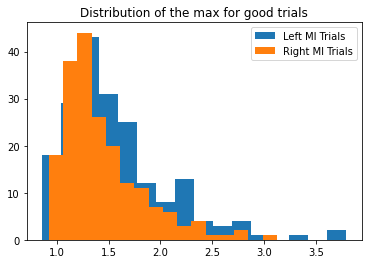

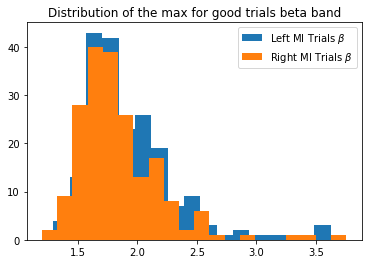

In [29]:
# check the distribution of the max_val
plt.figure()
plt.title('Distribution of the max for good trials')
plt.hist(good_trials['imagery_handL'].max(axis = (0,1)), bins='auto', label='Left MI Trials')
plt.hist(good_trials['imagery_handR'].max(axis = (0,1)), bins='auto', label='Right MI Trials')
plt.legend()
# plt.show()

# beta band
plt.figure()
plt.title('Distribution of the max for good trials beta band')
plt.hist(good_trials_b['imagery_handL'].max(axis = (0,1)), bins='auto', label=r'Left MI Trials $\beta$')
plt.hist(good_trials_b['imagery_handR'].max(axis = (0,1)), bins='auto', label=r'Right MI Trials $\beta$')
plt.legend()
plt.show()


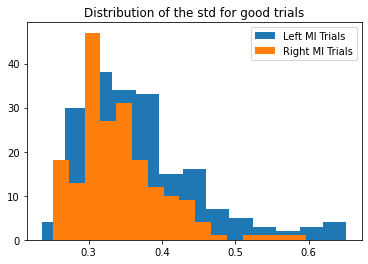

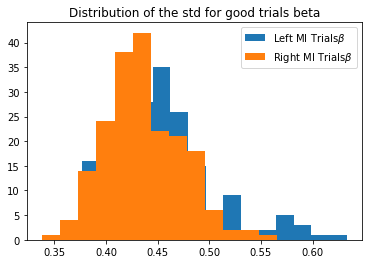

In [30]:
# check the distribution of the max_val
plt.figure()
plt.title('Distribution of the std for good trials')
plt.hist(good_trials['imagery_handL'].std(axis = (0,1)), bins='auto', label='Left MI Trials')
plt.hist(good_trials['imagery_handR'].std(axis = (0,1)), bins='auto', label='Right MI Trials')
plt.legend()
# plt.show()

# beta band
plt.figure()
plt.title('Distribution of the std for good trials beta')
plt.hist(good_trials_b['imagery_handL'].std(axis = (0,1)), bins='auto', label=r'Left MI Trials$\beta$')
plt.hist(good_trials_b['imagery_handR'].std(axis = (0,1)), bins='auto', label=r'Right MI Trials$\beta$')
plt.legend()
plt.show()

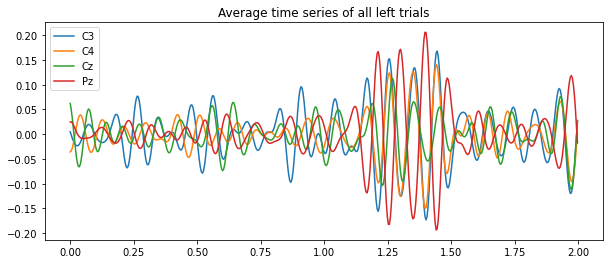

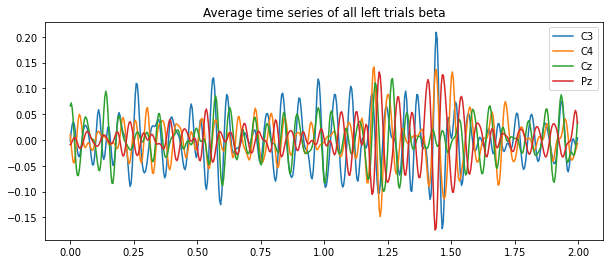

In [31]:
av_left_trials = trials['imagery_handL'].mean(axis = 2)
av_left_trials.shape
plt.figure(figsize=(10,4))
plt.tight_layout()

t = np.arange(0, int(av_left_trials.shape[1]/250), 1/fs)
for name in ['C3', 'C4', 'Cz', 'Pz']:
    plt.plot(t, av_left_trials[preprocess.name2channel(name)], label=name)
    
plt.title('Average time series of all left trials')
plt.legend()

# beta 
av_left_trials_b = trials_b['imagery_handL'].mean(axis = 2)
plt.figure(figsize=(10,4))
plt.tight_layout()

t = np.arange(0, int(av_left_trials_b.shape[1]/250), 1/fs)
for name in ['C3', 'C4', 'Cz', 'Pz']:
    plt.plot(t, av_left_trials_b[preprocess.name2channel(name)], label=name)
    
plt.title('Average time series of all left trials beta')
plt.legend()

plt.show()

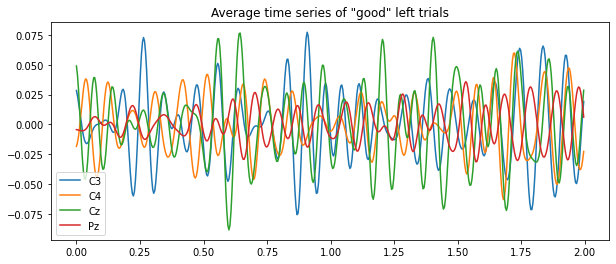

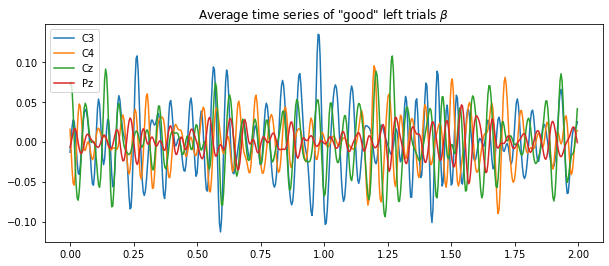

In [32]:
av_left_trials = good_trials['imagery_handL'].mean(axis = 2)
plt.figure(figsize=(10,4))
plt.tight_layout()

t = np.arange(0, int(av_left_trials.shape[1]/250), 1/fs)
for name in ['C3', 'C4', 'Cz', 'Pz']:
    plt.plot(t, av_left_trials[preprocess.name2channel(name)], label=name)
    
plt.title('Average time series of "good" left trials')    
plt.legend()

# beta
av_left_trials_b = good_trials_b['imagery_handL'].mean(axis = 2)
plt.figure(figsize=(10,4))
plt.tight_layout()

t = np.arange(0, int(av_left_trials_b.shape[1]/250), 1/fs)
for name in ['C3', 'C4', 'Cz', 'Pz']:
    plt.plot(t, av_left_trials_b[preprocess.name2channel(name)], label=name)
    
plt.title(r'Average time series of "good" left trials $\beta$')    
plt.legend()

plt.show()

# Analysis

In [33]:
# Print some information
print('Shape of EEG:', EEG.shape)
print('Sample rate:', fs)
print('Number of channels:', EEG.shape[0])
print('Channel names:', [preprocess.channel2name(channel) for channel in range(EEG.shape[0])])
print('Number of events:', len(event_onsets))
print('Event codes:', np.unique(event_codes))
print('Class labels:', cl_labs)
print('Class codes:', cl_codes)
print('Number of classes:', nclasses)

cl0 = cl_labs[0]
cl1 = cl_labs[1]

Shape of EEG: (8, 1023780)
Sample rate: 250
Number of channels: 8
Channel names: ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8']
Number of events: 1213
Event codes: [0 1 2 3 4 5 6 7]
Class labels: ['imagery_handL', 'imagery_handR']
Class codes: [7, 5]
Number of classes: 2


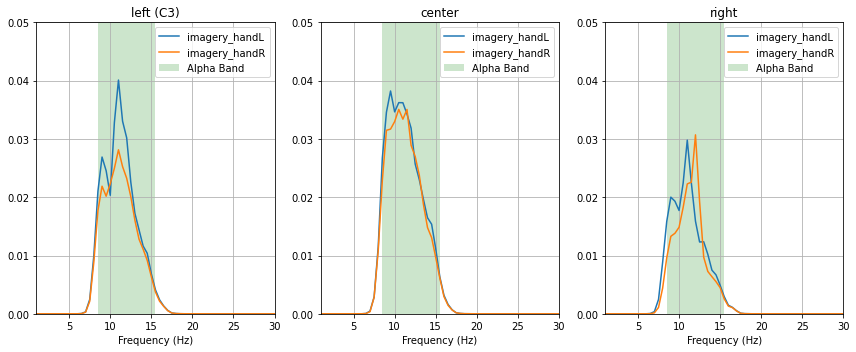

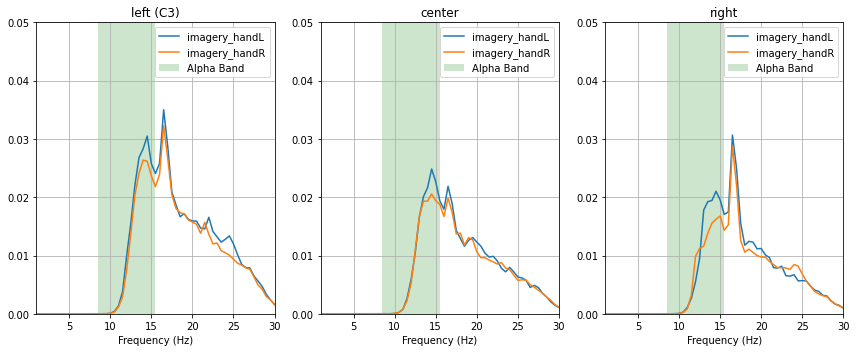

In [34]:
psd0, freqs, = analysis.psd(good_trials[cl0], nchannels, nsamples, fs)
psd1, freqs, = analysis.psd(good_trials[cl1], nchannels, nsamples, fs)
# beta
psd0_b, freqs, = analysis.psd(good_trials_b[cl0], nchannels, nsamples, fs)
psd1_b, freqs, = analysis.psd(good_trials_b[cl1], nchannels, nsamples, fs)

trials_PSD = {
    cl0: psd0, 
    cl1: psd1
}
# beta
trials_PSD_b = {
    cl0: psd0_b, 
    cl1: psd1_b
}

analysis.plot_psd(
    trials_PSD,
    freqs,
    [preprocess.name2channel(name) for name in ['C3', 'Cz', 'C4']],
    chan_lab=['left (C3)', 'center', 'right'],
    maxy=0.05
)
# beta
analysis.plot_psd(
    trials_PSD_b,
    freqs,
    [preprocess.name2channel(name) for name in ['C3', 'Cz', 'C4']],
    chan_lab=['left (C3)', 'center', 'right'],
    maxy=0.05
) # notice that the green fill is hard coded with alpha band for beta is 12.5-30Hz will need to modify the plot_psd function

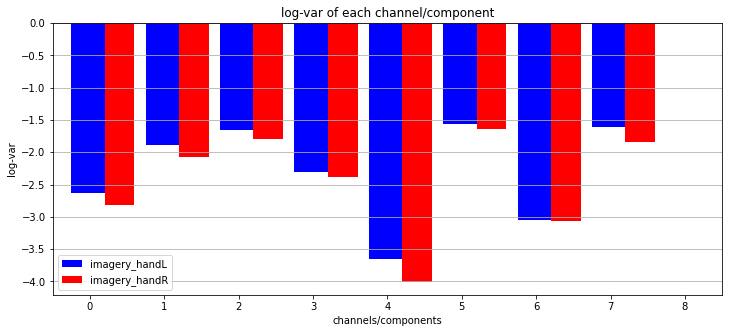

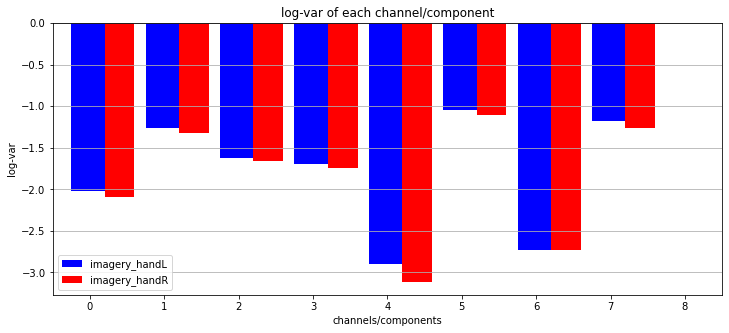

In [36]:
trials_logvar = {
    cl0: analysis.logvar(good_trials[cl0]),
    cl1: analysis.logvar(good_trials[cl1])
}
# beta band
trials_logvar_b = {
    cl0: analysis.logvar(good_trials_b[cl0]),
    cl1: analysis.logvar(good_trials_b[cl1])
}
analysis.plot_logvar(trials_logvar, cl_labs)
# beta band
analysis.plot_logvar(trials_logvar_b, cl_labs)

### CSP
Using CSP generates components which are easier to classify than the channels. 

Instead of 8 channels, we now have 8 mixtures of channels, called components. They are the result of 8 spatial filters applied to the data.

The first filters maximize the variation of the first class, while minimizing the variation of the second. The last filters maximize the variation of the second class, while minimizing the variation of the first.

This is also visible in a PSD plot.

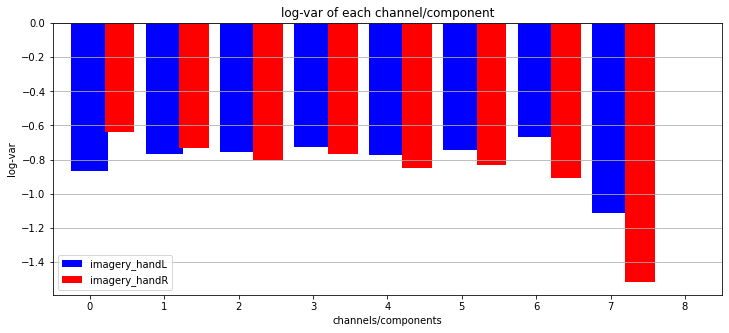

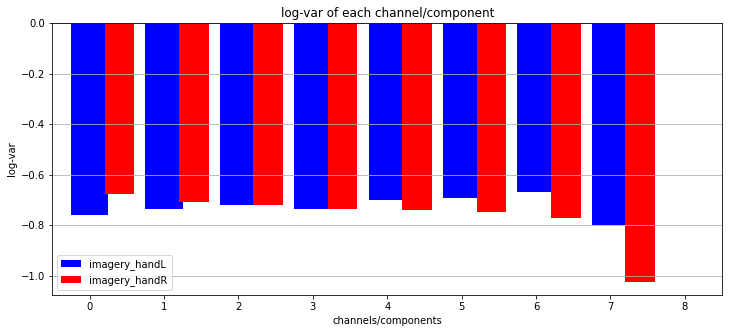

In [37]:
csp = preprocess.CSP(good_trials, cl_labs, nsamples, nchannels)
# beta 
csp_b = preprocess.CSP(good_trials_b, cl_labs, nsamples, nchannels)

trials_csp = csp.get_csp_trials()
# beta
trials_csp_b = csp_b.get_csp_trials()

trials_csp_logvar = {
    cl0: analysis.logvar(trials_csp[cl0]),
    cl1: analysis.logvar(trials_csp[cl1])
}
# beta
trials_csp_logvar_b = {
    cl0: analysis.logvar(trials_csp_b[cl0]),
    cl1: analysis.logvar(trials_csp_b[cl1])
}
analysis.plot_logvar(trials_csp_logvar, cl_labs)
analysis.plot_logvar(trials_csp_logvar_b, cl_labs)

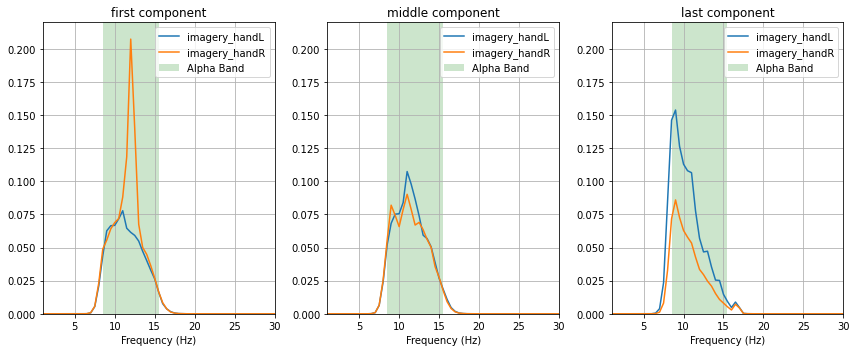

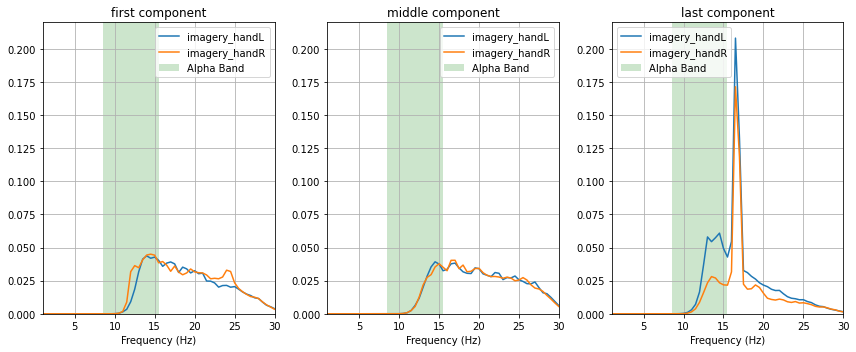

In [38]:
psd0, freqs, = analysis.psd(trials_csp[cl0], nchannels, nsamples, fs)
psd1, freqs, = analysis.psd(trials_csp[cl1], nchannels, nsamples, fs)
# beta
psd0_b, freqs, = analysis.psd(trials_csp_b[cl0], nchannels, nsamples, fs)
psd1_b, freqs, = analysis.psd(trials_csp_b[cl1], nchannels, nsamples, fs)

trials_csp_PSD = {
    cl0: psd0, 
    cl1: psd1
}
# beta
trials_csp_PSD_b = {
    cl0: psd0_b, 
    cl1: psd1_b
}
analysis.plot_psd(
    trials_csp_PSD,
    freqs,
    [0,3,-1],
    chan_lab=['first component', 'middle component', 'last component'],
    maxy=0.22
)
# beta
analysis.plot_psd(
    trials_csp_PSD_b,
    freqs,
    [0,3,-1],
    chan_lab=['first component', 'middle component', 'last component'],
    maxy=0.22
)

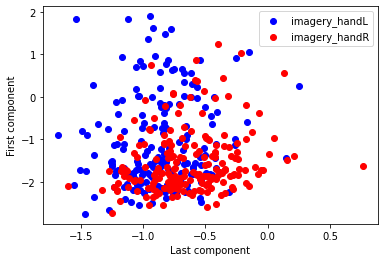

In [38]:
analysis.plot_scatter(trials_csp_logvar[cl0], trials_csp_logvar[cl1], cl_labs)

## LDA

In [40]:
train_percentage = 0.8


# Calculate the number of trials for each class the above percentage boils down to
ntrain_cl0 = int(good_trials[cl0].shape[2] * train_percentage)
ntrain_cl1 = int(good_trials[cl1].shape[2] * train_percentage)
ntest_cl0 = good_trials[cl0].shape[2] - ntrain_cl0
ntest_cl1 = good_trials[cl1].shape[2] - ntrain_cl1
# beta
ntrain_cl0_b = int(good_trials_b[cl0].shape[2] * train_percentage)
ntrain_cl1_b = int(good_trials_b[cl1].shape[2] * train_percentage)
ntest_cl0_b = good_trials_b[cl0].shape[2] - ntrain_cl0_b
ntest_cl1_b = good_trials_b[cl1].shape[2] - ntrain_cl1_b

print(f'Training datapoints: ({cl0}: {ntrain_cl0}; {cl1}: {ntrain_cl1})')
print(f'Testing datapoints: ({cl0}: {ntest_cl0}; {cl1}: {ntest_cl1})')

# beta
print(f'Training datapoints beta: ({cl0}: {ntrain_cl0_b}; {cl1}: {ntrain_cl1_b})')
print(f'Testing datapoints beta: ({cl0}: {ntest_cl0_b}; {cl1}: {ntest_cl1_b})')

Training datapoints: (imagery_handL: 155; imagery_handR: 155)
Testing datapoints: (imagery_handL: 39; imagery_handR: 39)
Training datapoints beta: (imagery_handL: 158; imagery_handR: 156)
Testing datapoints beta: (imagery_handL: 40; imagery_handR: 39)


In [41]:
# Splitting the filtered and cleaned signal into a train and test set
train = {
    cl0: good_trials[cl0][:,:,:ntrain_cl0],
    cl1: good_trials[cl1][:,:,:ntrain_cl1]
}

test = {
    cl0: good_trials[cl0][:,:,ntrain_cl0:],
    cl1: good_trials[cl1][:,:,ntrain_cl1:]
}
# beta
train_b = {
    cl0: good_trials_b[cl0][:,:,:ntrain_cl0_b],
    cl1: good_trials_b[cl1][:,:,:ntrain_cl1_b]
}

test_b = {
    cl0: good_trials_b[cl0][:,:,ntrain_cl0_b:],
    cl1: good_trials_b[cl1][:,:,ntrain_cl1_b:]
}

print(f'Training dataset: ({cl0}: {train[cl0].shape}; {cl1}: {train[cl0].shape})')
print(f'Testing dataset: ({cl0}: {test[cl0].shape}; {cl1}: {test[cl1].shape})')

# beta
print(f'Training dataset beta: ({cl0}: {train_b[cl0].shape}; {cl1}: {train_b[cl0].shape})')
print(f'Testing dataset beta: ({cl0}: {test_b[cl0].shape}; {cl1}: {test_b[cl1].shape})')

Training dataset: (imagery_handL: (8, 500, 155); imagery_handR: (8, 500, 155))
Testing dataset: (imagery_handL: (8, 500, 39); imagery_handR: (8, 500, 39))
Training dataset beta: (imagery_handL: (8, 500, 158); imagery_handR: (8, 500, 158))
Testing dataset beta: (imagery_handL: (8, 500, 40); imagery_handR: (8, 500, 39))


In [44]:
train_csp = preprocess.CSP(train, cl_labs, nsamples, nchannels)
train_csp_components = train_csp.get_csp_trials()
W = train_csp.get_W()
print(W.shape)
print(train_csp_components[cl0].shape)

# beta
train_csp_b = preprocess.CSP(train_b, cl_labs, nsamples, nchannels)
train_csp_components_b = train_csp_b.get_csp_trials()
W_b = train_csp_b.get_W()
print(W_b.shape)
print(train_csp_components_b[cl0].shape)

# test set
test_csp = preprocess.CSP(test, cl_labs, nsamples, nchannels, W=W)
test_csp_components = test_csp.get_csp_trials()
print(test_csp_components[cl0].shape)

# beta
test_csp_b = preprocess.CSP(test_b, cl_labs, nsamples, nchannels, W=W_b)
test_csp_components_b = test_csp_b.get_csp_trials()
print(test_csp_components_b[cl0].shape)

(8, 8)
(8, 500, 155)
(8, 8)
(8, 500, 158)
(8, 500, 39)
(8, 500, 40)


(8, 155)
(8, 158)


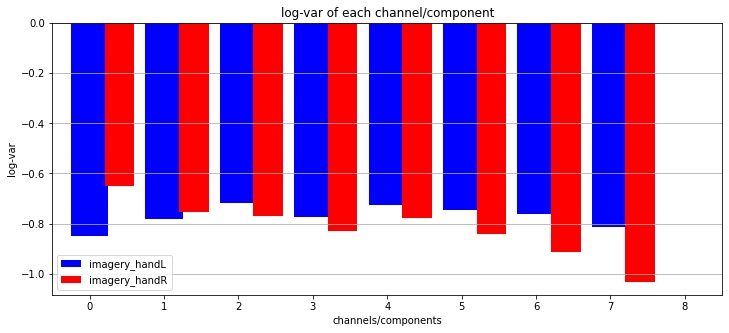

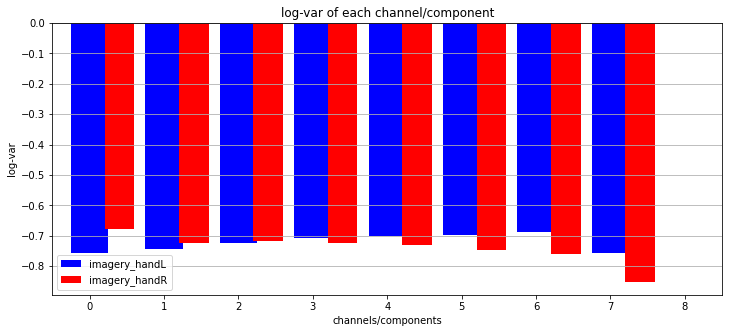

In [46]:
train_csp_logvar = {
    cl0: analysis.logvar(train_csp_components[cl0]),
    cl1: analysis.logvar(train_csp_components[cl1])
}
test_csp_logvar = {
    cl0: analysis.logvar(test_csp_components[cl0]),
    cl1: analysis.logvar(test_csp_components[cl1])
}

print(train_csp_logvar[cl0].shape)

analysis.plot_logvar(train_csp_logvar, cl_labs)

# beta
train_csp_logvar_b = {
    cl0: analysis.logvar(train_csp_components_b[cl0]),
    cl1: analysis.logvar(train_csp_components_b[cl1])
}
test_csp_logvar_b = {
    cl0: analysis.logvar(test_csp_components_b[cl0]),
    cl1: analysis.logvar(test_csp_components_b[cl1])
}

print(train_csp_logvar_b[cl0].shape)

analysis.plot_logvar(train_csp_logvar_b, cl_labs)


(2, 500, 155)
(2, 500, 39)
(2, 500, 158)
(2, 500, 40)
(2, 155)
(2, 158)


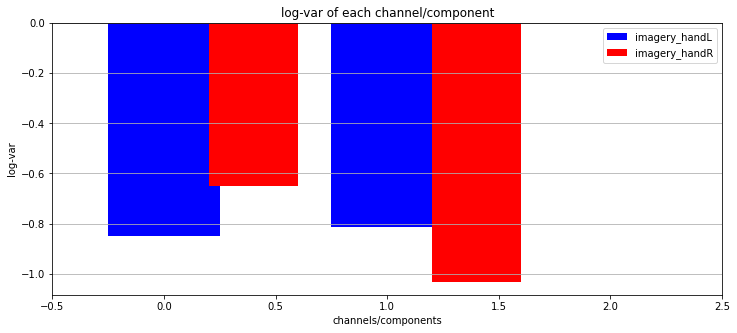

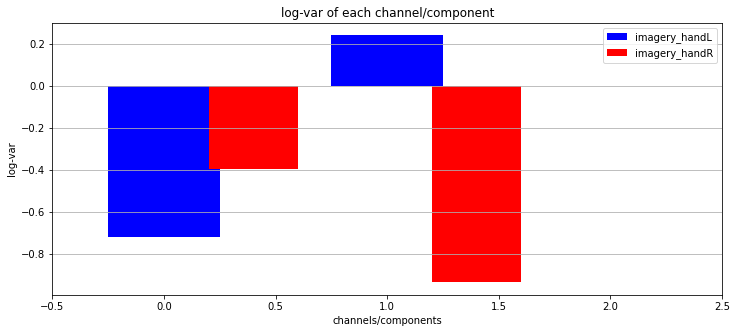

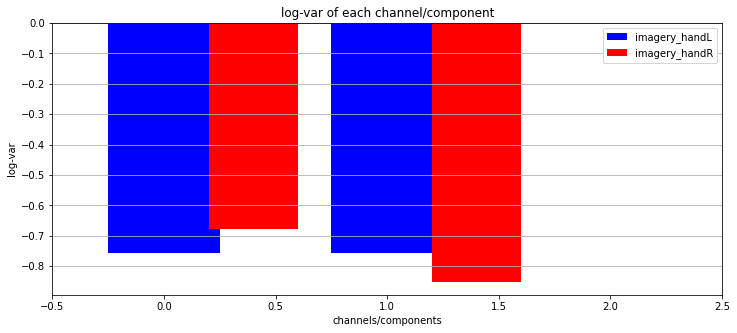

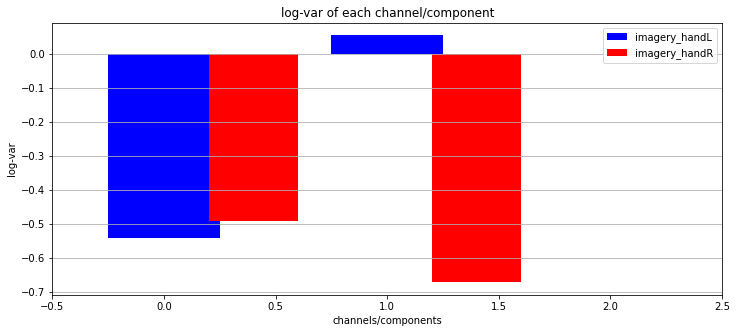

In [47]:
# Select only the first and last components for classification
comp = np.array([0,-1])

train_csp_selection = {
    cl0: train_csp_components[cl0][comp,:,:],
    cl1: train_csp_components[cl1][comp,:,:]
}
print(train_csp_selection[cl0].shape)

test_csp_selection = {
    cl0: test_csp_components[cl0][comp,:,:],
    cl1: test_csp_components[cl1][comp,:,:]
}
print(test_csp_selection[cl0].shape)

# beta
comp = np.array([0,-1])

train_csp_selection_b = {
    cl0: train_csp_components_b[cl0][comp,:,:],
    cl1: train_csp_components_b[cl1][comp,:,:]
}
print(train_csp_selection_b[cl0].shape)

test_csp_selection_b = {
    cl0: test_csp_components_b[cl0][comp,:,:],
    cl1: test_csp_components_b[cl1][comp,:,:]
}
print(test_csp_selection_b[cl0].shape)

# Recalculate the log-var
train_csp_logvar = {
    cl0: analysis.logvar(train_csp_selection[cl0]),
    cl1: analysis.logvar(train_csp_selection[cl1])
}
print(train_csp_logvar[cl0].shape)

test_csp_logvar = {
    cl0: analysis.logvar(test_csp_selection[cl0]),
    cl1: analysis.logvar(test_csp_selection[cl1])
}


analysis.plot_logvar(train_csp_logvar, cl_labs)
analysis.plot_logvar(test_csp_logvar, cl_labs)

# beta
train_csp_logvar_b = {
    cl0: analysis.logvar(train_csp_selection_b[cl0]),
    cl1: analysis.logvar(train_csp_selection_b[cl1])
}
print(train_csp_logvar_b[cl0].shape)

test_csp_logvar_b = {
    cl0: analysis.logvar(test_csp_selection_b[cl0]),
    cl1: analysis.logvar(test_csp_selection_b[cl1])
}


analysis.plot_logvar(train_csp_logvar_b, cl_labs)
analysis.plot_logvar(test_csp_logvar_b, cl_labs)

In [48]:
def train_lda(class1, class2):
    '''
    Trains the LDA algorithm.
    arguments:
        class1 - An array (observations x features) for class 1
        class2 - An array (observations x features) for class 2
    returns:
        The projection matrix W
        The offset b
    '''
    nclasses = 2
    
    nclass1 = class1.shape[0]
    nclass2 = class2.shape[0]
    
    # Class priors: in this case, we have an equal number of training
    # examples for each class, so both priors are 0.5
    prior1 = nclass1 / float(nclass1 + nclass2)
    prior2 = nclass2 / float(nclass1 + nclass1)
   
    mean1 = np.mean(class1, axis=0)
    mean2 = np.mean(class2, axis=0)
    
    class1_centered = class1 - mean1
    class2_centered = class2 - mean2
    
    # Calculate the covariance between the features
    cov1 = class1_centered.T.dot(class1_centered) / (nclass1 - nclasses)
    cov2 = class2_centered.T.dot(class2_centered) / (nclass2 - nclasses)
   
    W = (mean2 - mean1).dot(np.linalg.pinv(prior1*cov1 + prior2*cov2))
    b = (prior1*mean1 + prior2*mean2).dot(W)
    
    return (W,b)

def apply_lda(test, W, b):
    '''
    Applies a previously trained LDA to new data.
    arguments:
        test - An array (features x trials) containing the data
        W    - The project matrix W as calculated by train_lda()
        b    - The offsets b as calculated by train_lda()
    returns:
        A list containing a classlabel for each trial
    '''
    ntrials = test.shape[1]
    
    prediction = []
    for i in range(ntrials):
        # The line below is a generalization for:
        # result = W[0] * test[0,i] + W[1] * test[1,i] - b
        result = W.dot(test[:,i]) - b
        if result <= 0:
            prediction.append(1)
        else:
            prediction.append(2)
    
    return np.array(prediction)

In [52]:
print((train_csp_logvar[cl0].T).shape)
print((train_csp_logvar_b[cl0].T).shape)

(155, 2)
(158, 2)


In [53]:
# concatenate the result from above steps (alpha and beta are caculate seperately)
W,b = train_lda(np.concatenate((train_csp_logvar[cl0].T, train_csp_logvar_b[cl0].T)), np.concatenate((train_csp_logvar[cl1].T, train_csp_logvar_b[cl1].T)))

print('W:', W)
print('b:', b)

W: [ 2.14318582 -0.77060478]
b: -0.9041679408538645


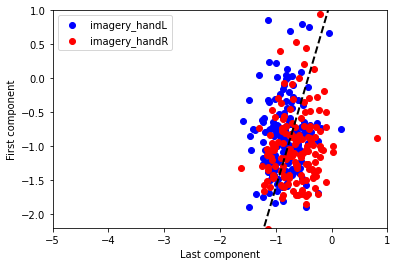

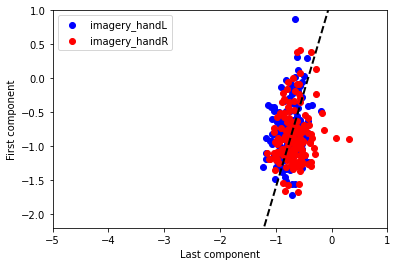

In [54]:
# Scatterplot like before
analysis.plot_scatter(train_csp_logvar[cl0], train_csp_logvar[cl1], cl_labs)


# Calculate decision boundary (x,y)
x = np.arange(-5, 1, 0.1)
y = (b - W[0]*x) / W[1]

# Plot the decision boundary
plt.plot(x,y, linestyle='--', linewidth=2, color='k')
plt.xlim(-5, 1)
plt.ylim(-2.2, 1)
# plt.show()

# beta 
# (so i apply the W and b caculate using both alpha and beta features but plot it on different dataset im sooo unsure about this)
analysis.plot_scatter(train_csp_logvar_b[cl0], train_csp_logvar_b[cl1], cl_labs)
# Plot the decision boundary
plt.plot(x,y, linestyle='--', linewidth=2, color='k')
plt.xlim(-5, 1)
plt.ylim(-2.2, 1)
plt.show()

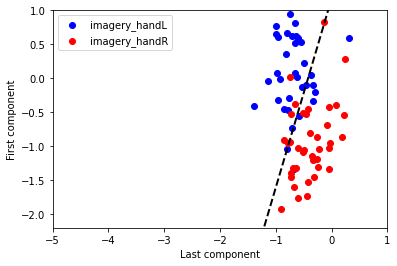

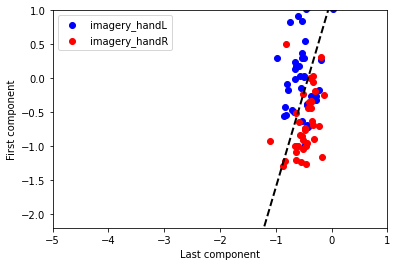

In [56]:
analysis.plot_scatter(test_csp_logvar[cl0], test_csp_logvar[cl1], cl_labs)
plt.plot(x,y, linestyle='--', linewidth=2, color='k')
plt.xlim(-5, 1)
plt.ylim(-2.2, 1)
plt.show()

# beta
analysis.plot_scatter(test_csp_logvar_b[cl0], test_csp_logvar_b[cl1], cl_labs)
plt.plot(x,y, linestyle='--', linewidth=2, color='k')
plt.xlim(-5, 1)
plt.ylim(-2.2, 1)
plt.show()

In [61]:
# Print confusion matrix
conf = np.array([
    [(apply_lda(test_csp_logvar[cl0], W, b) == 1).sum(), 
    (apply_lda(test_csp_logvar[cl1], W, b) == 1).sum()],
    [(apply_lda(test_csp_logvar[cl0], W, b) == 2).sum(), 
    (apply_lda(test_csp_logvar[cl1], W, b) == 2).sum()],
])

print('Confusion matrix:')
print(conf)
print()
print('Accuracy: %.3f' % (np.sum(np.diag(conf)) / float(np.sum(conf))))

#beta
conf_b = np.array([
    [(apply_lda(test_csp_logvar_b[cl0], W, b) == 1).sum(), 
    (apply_lda(test_csp_logvar_b[cl1], W, b) == 1).sum()],
    [(apply_lda(test_csp_logvar_b[cl0], W, b) == 2).sum(), 
    (apply_lda(test_csp_logvar_b[cl1], W, b) == 2).sum()],
])
print()
print(r'Confusion matrix for $\beta$:')
print(conf_b)
print()
print('Accuracy_beta: %.3f' % (np.sum(np.diag(conf_b)) / float(np.sum(conf_b))))

Confusion matrix:
[[32  6]
 [ 7 33]]

Accuracy: 0.833

Confusion matrix for $\beta$:
[[28  3]
 [12 36]]

Accuracy_beta: 0.810


## Replicate results with sklearn 

In [85]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as skLDA
from sklearn.metrics import confusion_matrix

In [101]:
# Train
X_cl0 = train_csp_logvar[cl0].T
y_cl0 = np.zeros(X_cl0.shape[0])
X_cl1 = train_csp_logvar[cl1].T
y_cl1 = np.ones(X_cl0.shape[0])

X_train = np.concatenate([X_cl0, X_cl1], axis=0)
y_train = np.concatenate([y_cl0, y_cl1], axis=0)

print(X_train.shape, y_train.shape)

# Test
X_cl0 = test_csp_logvar[cl0].T
y_cl0 = np.zeros(X_cl0.shape[0])
X_cl1 = test_csp_logvar[cl1].T
y_cl1 = np.ones(X_cl0.shape[0])

X_test = np.concatenate([X_cl0, X_cl1], axis=0)
y_test = np.concatenate([y_cl0, y_cl1], axis=0)
print(X_test.shape, y_test.shape)

(310, 2) (310,)
(78, 2) (78,)


In [102]:
clf_lda = skLDA()
clf_lda.fit(X_train, y_train)

ypred = clf_lda.predict(X_test)

print(f'LDA Accuracy: {np.sum(ypred == y_test) / ypred.size}')

print(confusion_matrix(y_test, ypred))

LDA Accuracy: 0.8333333333333334
[[32  7]
 [ 6 33]]


In [104]:
y_train_pred = clf_lda.predict(X_train)
print(f'LDA Accuracy: {np.sum(y_train_pred == y_train) / y_train_pred.size}')


LDA Accuracy: 0.6580645161290323


In [95]:
# Try out an SVM

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [100]:
clf_svm = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf_svm.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(f'SVM Accuracy: {np.sum(y_pred == y_test) / y_pred.size}')
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.7948717948717948
[[32  7]
 [ 9 30]]


## Using Cross validation

In [123]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

X = np.concatenate([X_test, X_train], axis=0)
y = np.concatenate([y_test, y_train], axis=0)
print('All', X.shape,y.shape)

cv = 5

All (388, 2) (388,)


In [125]:
# SVM
clf = SVC(kernel='linear', C=1, random_state=42)
scores = cross_val_score(clf, X, y, cv=cv)

print(f'SVM mean score for {cv} folds: {scores.mean()}')

SVM mean score for 5 folds: 0.6882117882117882


In [126]:
# LDA
clf_lda = skLDA()
scores = cross_val_score(clf_lda, X, y, cv=5)
print(f'LDA mean score for {cv} folds: {scores.mean()}')

LDA mean score for 5 folds: 0.6805194805194805
